<a href="https://colab.research.google.com/github/yashmehra028/so-fifa/blob/main/so_fifa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import requests
from bs4 import BeautifulSoup as bs

In [ ]:
def get_players_links(n_pages):
    offset = range(0,60*n_pages,60)
    player_links = []

    for offset_value in offset:
        r = requests.get(f'https://sofifa.com/players?offset={offset_value}')
        all_players_page = bs(r.content)
        tables = all_players_page.select('td.col-name')
        for table in tables:
            a_tag = table.find('a')
            url = a_tag['href']
            if 'player' in url and 'players' not in url:
                player_links.append('https://sofifa.com' + url)

    return player_links

player_links = get_players_links(5)

In [ ]:
len(player_links)

300

In [ ]:
import re

def get_name(player_page):

    name_div = player_page.find('div',attrs={'class':'info'})
    return [('Name',name_div.find('h1').get_text())]

def get_section_box(player_page):

    info_list = []

    for initial_info in player_page.select('section'):
        text = initial_info.get_text()
    
    if 'M' in text:
        text = text.replace('M','')
    if 'K' in text:
        text = text.replace('K','')
    
    pattern = re.compile(r'[+-]\d{1,2}')
    if pattern.findall(text):
        for i in pattern.findall(text):
            text = text.replace(i,'').strip()

    
    pattern_num = re.compile(r'\d+[\.\d+]*')
    pattern_text = re.compile(r'[A-Za-z]+')
    
    num_list = pattern_num.findall(text)
    char_list = pattern_text.findall(text)
    char_list[0] += ' ' + char_list[1]
    char_list.pop(1)

    for i in range(len(num_list)):
        info_list.append((char_list[i],float(num_list[i])))

    return info_list

def get_skills(player_page):

    valid_fields = ['Attacking', 'Skill', 'Movement','Power', 'Mentality', 'Defending', 'Goalkeeping']

    info_list = []
    divs = [i for i in player_page.select('div.card')]

    valid_divs = []
    for i in divs:
        if i.select('h5'):
            if i.select('h5')[0].get_text() in valid_fields:
                valid_divs.append(i)

    
    for i in valid_divs:
        info = [j.get_text().strip() for j in i.select('li')]
        
        for j in info:
            pattern_num = re.compile(r'\d+')
            pattern_text = re.compile(r'[A-Za-z]+\s*[A-Za-z]*')

            try:
                num = pattern_num.findall(j)[0]
                char = pattern_text.findall(j)[0]
                info_list.append((char,float(num)))
                
            except:
                pass


    return info_list


def get_height_weight(player_page):

    info_list = []

    all_text = player_page.find('div',attrs={'class':'meta ellipsis'}).get_text()
    nationality = player_page.find('div',attrs={'class':'meta ellipsis'}).find('a')['title']
    info_list.append(('Nationality',nationality))

    body_measures = ['Age','Height','Weight']

    pattern = re.compile(r'\d+[c|k|y]')
    values = pattern.findall(all_text)

    for i in range(len(values)):
        info_list.append((body_measures[i],float(values[i][:len(values[i])-1])))

    return info_list


def get_player_info(player_link):
    r = requests.get(player_link)
    player_page = bs(r.content)

    a = get_section_box(player_page)
    b = get_name(player_page)
    c = get_skills(player_page)
    d = get_height_weight(player_page)

    return a + b + c + d

In [ ]:
get_player_info('https://sofifa.com/player/1041/javier-zanetti/140041/')

In [ ]:
result = []
for link in player_links[:20]:
    info_dict = {i[0]:i[1] for i in get_player_info(link)}
    result.append(info_dict)


In [ ]:
len(result)

20

In [ ]:
import pandas as pd

df = pd.DataFrame(result)

In [ ]:
df

,Overall Rating,Potential,Value,Wage,Name,Crossing,Finishing,Heading Accuracy,Short Passing,Volleys,...,Sliding Tackle,GK Diving,GK Handling,GK Kicking,GK Positioning,GK Reflexes,Nationality,Age,Height,Weight
0,83.0,89.0,58.5,95.0,Martin Ødegaard,84.0,75.0,52.0,83.0,76.0,...,51.0,14.0,15.0,15.0,8.0,10.0,Norway,22.0,178.0,68.0
1,82.0,90.0,68.5,130.0,Ferran Torres García,77.0,81.0,75.0,80.0,74.0,...,28.0,12.0,9.0,11.0,15.0,12.0,Spain,21.0,184.0,77.0
2,76.0,88.0,17.0,14.0,Pablo Martín Páez Gavira,62.0,63.0,42.0,81.0,46.0,...,62.0,8.0,10.0,11.0,7.0,13.0,Spain,16.0,173.0,68.0
3,74.0,82.0,9.5,67.0,Ricard Puig Martí,60.0,63.0,49.0,80.0,56.0,...,53.0,12.0,15.0,14.0,12.0,9.0,Spain,21.0,169.0,56.0
4,79.0,84.0,24.0,39.0,Gleison Bremer Silva Nascimento,40.0,40.0,81.0,69.0,36.0,...,80.0,13.0,15.0,13.0,5.0,6.0,Brazil,24.0,188.0,82.0
5,83.0,88.0,55.0,165.0,Ousmane Dembélé,81.0,75.0,43.0,78.0,76.0,...,33.0,6.0,6.0,14.0,10.0,13.0,France,24.0,178.0,67.0
6,84.0,91.0,85.5,130.0,Kai Lukas Havertz,72.0,81.0,78.0,84.0,80.0,...,38.0,6.0,8.0,11.0,10.0,12.0,Germany,22.0,189.0,82.0
7,76.0,88.0,18.0,53.0,Armando Broja,40.0,78.0,69.0,65.0,64.0,...,23.0,9.0,7.0,15.0,8.0,9.0,Albania,19.0,191.0,75.0
8,77.0,77.0,2.3,71.0,Daniel Alves da Silva,80.0,63.0,59.0,79.0,67.0,...,73.0,5.0,11.0,9.0,6.0,7.0,Brazil,38.0,172.0,70.0
9,81.0,86.0,31.0,58.0,Aaron Ramsdale,15.0,14.0,15.0,54.0,16.0,...,15.0,82.0,77.0,84.0,78.0,84.0,England,23.0,191.0,77.0


In [ ]:
nations_group = df.groupby('Nationality')

In [ ]:
av_rating = []
for country, df in nations_group:
    av_rating.append((country,df['Overall Rating'].sum()/len(df['Overall Rating'])))
    
av_rating.sort(key=lambda x:x[1],reverse=True)

In [ ]:
rating = [i[1] for i in av_rating]
countries = [i[0] for i in av_rating]

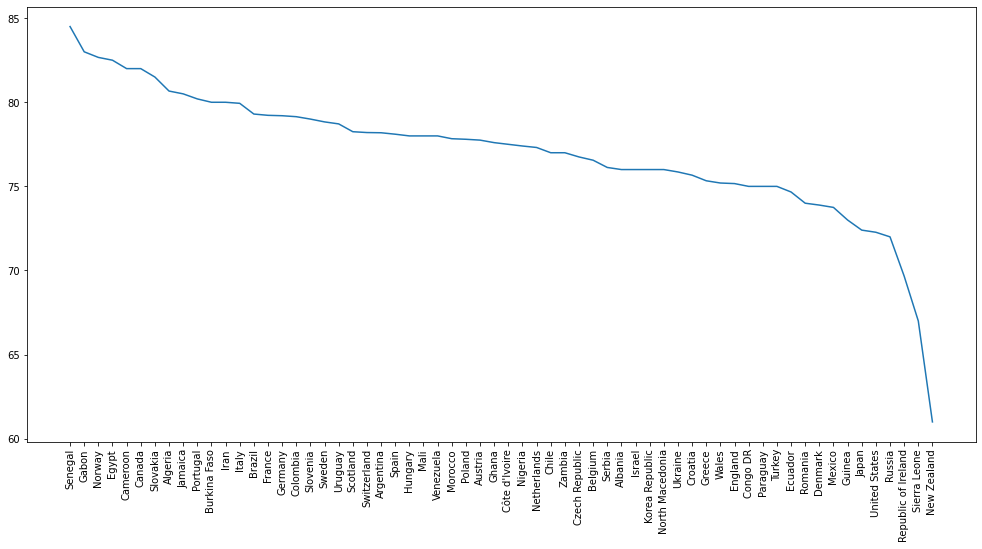

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(17,8))
plt.xticks(rotation = 90)
plt.plot(countries,rating)


In [ ]:
https://www.imdb.com/search/title/?country_of_origin=IN&start=1001&ref_=adv_nxt

In [ ]:
import requests
from bs4 import BeautifulSoup as bs

def get_movie_links(n_pages):

    all_movie_links = []

    url = 'https://www.imdb.com/search/title/?country_of_origin=IN&start=201&ref_=adv_nxt'
    start_values = range(1,n_pages*50,50)
    for start in start_values:
        url = f'https://www.imdb.com/search/title/?country_of_origin=IN&start={start}&ref_=adv_nxt'
        r = requests.get(url)
        all_links_page = bs(r.content)
        h3_tags = all_links_page.select('h3')
        for tag in h3_tags:
            try:
                movie_url = tag.find('a')['href']
                full_url = f'https://www.imdb.com{movie_url}?ref_=adv_li_tt'
                all_movie_links.append(full_url)
            
            except:
                pass
        

    return all_movie_links
get_movie_links(3) 

['https://www.imdb.com/title/tt9447956/?ref_=adv_li_tt',
 'https://www.imdb.com/title/tt10083340/?ref_=adv_li_tt',
 'https://www.imdb.com/title/tt13028258/?ref_=adv_li_tt',
 'https://www.imdb.com/title/tt10806040/?ref_=adv_li_tt',
 'https://www.imdb.com/title/tt14486948/?ref_=adv_li_tt',
 'https://www.imdb.com/title/tt10733228/?ref_=adv_li_tt',
 'https://www.imdb.com/title/tt13364468/?ref_=adv_li_tt',
 'https://www.imdb.com/title/tt13868972/?ref_=adv_li_tt',
 'https://www.imdb.com/title/tt12392496/?ref_=adv_li_tt',
 'https://www.imdb.com/title/tt14209560/?ref_=adv_li_tt',
 'https://www.imdb.com/title/tt8983228/?ref_=adv_li_tt',
 'https://www.imdb.com/title/tt15097216/?ref_=adv_li_tt',
 'https://www.imdb.com/title/tt12472554/?ref_=adv_li_tt',
 'https://www.imdb.com/title/tt14002046/?ref_=adv_li_tt',
 'https://www.imdb.com/title/tt9389998/?ref_=adv_li_tt',
 'https://www.imdb.com/title/tt16729514/?ref_=adv_li_tt',
 'https://www.imdb.com/title/tt1187043/?ref_=adv_li_tt',
 'https://www.imdb